<a href="https://colab.research.google.com/github/meixinzhang/rigid-moving-objects/blob/main/rigid-moving-object.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Some Title

Meixin Zhang, 

At the top, the notebook should have a clear title, your name,

### *Abstract*

a separate cell with a concise two-three paragraph abstract outlining the high-level goal and discussing well-motivated methodology of the project. 


### Team Members and Contributions

This cell should contain an itemized list of all team members. Each item (bullet) should start with a name and detail this person's contributions. 

- Meixin: 


### Code Libraries

You should also have a separate cell titled code libraries acknowledging all external code libraries "essential" for your project. You should explain the importance of each such library for your project. 

If these libraries are not installed with the default anaconda package, provide installation instructions/links or include the necessary files in extlibs subdirectory. 

If needed, for better organization and clarity of your project you can write your own code libraries that should be summarized in this section as well. The corresponding (.py) files should be included in mylibs subdirectory. For group projects, you can refer to your team's libraries in the earlier "contributions" section. At the bottom of your notebook, you should include a cell with two-three paragraphs summarizing the conclusions of your project.


## Implementation

Unsupervised detection and segmentation of (multiple) rigidly moving objects. 

You can detect multiple fundamental matrices while matching sparse features (Topics 6-7) and integrate these into loss functions for dense segmentation (topic 9). Essentially, this can be implemented as a combination of methods in HW3 and HW4. You can use any (pairs of) images for this project

Different parts of an image going through different kinds of movements (different essential/fundamental matrices)  - UFL

Use RANSAC/UFL for inlier matches multiple times, then find different fundamental matrices from that. Generate points from the surface based on the matrices. Ideally these should be on the same objects(A2)

Use the generated points (on the same reconstructed surfaces) as points that are ground truth, come up with the loss function (?) (A4)

## Structure from Motion Using UFL and Epipolar Geometry

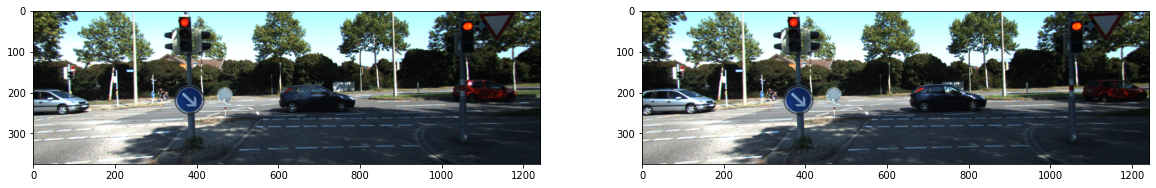

In [2]:
%matplotlib inline

import numpy as np
import numpy.linalg as la
import matplotlib
import matplotlib.image as image
import matplotlib.pyplot as plt
from skimage.feature import (corner_harris, corner_peaks, plot_matches, BRIEF, match_descriptors)
from skimage.transform import warp, ProjectiveTransform, EssentialMatrixTransform
from skimage.color import rgb2gray

# REPLACE RANSAC WITH UFL
from skimage.measure import ransac

# Indicate (E) inlier matches in image 1 and image 2
# loading two images (two camera views) and the corresponding matrix K (intrinsic parameters)
imL = image.imread("images/car1_left.png")
imR = image.imread("images/car1_right.png")
imLgray = rgb2gray(imL)
imRgray = rgb2gray(imR)

# using K_02 from calibration.txt
K = 1.0e+02 * np.array([[9.597910,        0, 6.960217],
                        [       0, 9.569251, 2.241806],
                        [       0,        0,    0.010]])

plt.figure(0,figsize = (20, 8))
ax81 = plt.subplot(121)
plt.imshow(imL)
ax82 = plt.subplot(122)
plt.imshow(imR)
plt.show()

#### Step 1: Feature Detection and Matching

Detect corners on the pictures and match using BRIEF descriptor.

the number of features in images 1 and 2 are   249 and   249
the number of matches is 195


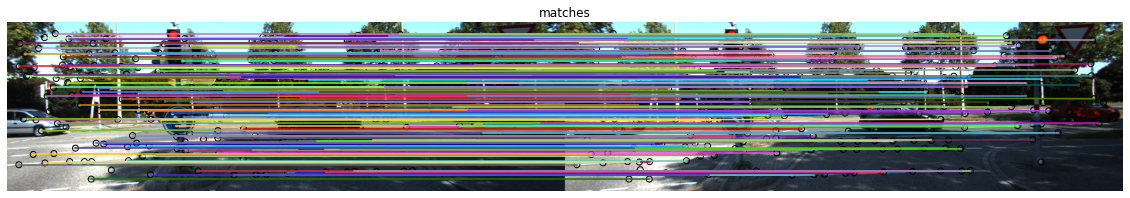

In [3]:
# NOTE: corner_peaks and many other feature extraction functions return point coordinates as (y,x), that is (rows,cols)
keypointsL = corner_peaks(corner_harris(imLgray), threshold_rel=0.001, min_distance=15)
keypointsR = corner_peaks(corner_harris(imRgray), threshold_rel=0.001, min_distance=15)
print ('the number of features in images 1 and 2 are {:5d} and {:5d}'.format(keypointsL.shape[0], keypointsR.shape[0]))

extractor = BRIEF()
extractor.extract(imLgray, keypointsL)
keypointsL = keypointsL[extractor.mask]         
descriptorsL = extractor.descriptors
extractor.extract(imRgray, keypointsR)
keypointsR = keypointsR[extractor.mask]
descriptorsR = extractor.descriptors

matchesLR = match_descriptors(descriptorsL, descriptorsR, cross_check=True)
print ('the number of matches is {:2d}'.format(matchesLR.shape[0]))

fig = plt.figure(2, figsize = (20, 8))
axA = plt.subplot(111)
axA.set_title("matches")
plt.gray()
plot_matches(axA, imL, imR, keypointsL, keypointsR, matchesLR) #, matches_color = 'r')
axA.axis('off')

plt.show()

#### Step 2: Camera Normalization and Essential Matrix estimation using UFL

the number of inliers is 189


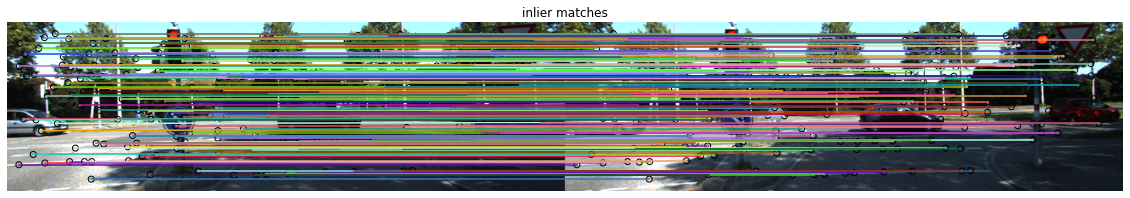

In [10]:
ptsL1 = []
ptsR1 = []
for i in matchesLR:
  ptsL1.append(keypointsL[i[0]])
  ptsR1.append(keypointsR[i[1]])
ptsL1 = np.array(ptsL1)
ptsR1 = np.array(ptsR1)
# swapping columns using advanced indexing https://docs.scipy.org/doc/numpy/reference/arra
# This changes point coordinates from (y,x) in ptsL1/ptsR1 to (x,y) in ptsL/ptsR
ptsL = ptsL1[:,[1, 0]]
ptsR = ptsR1[:,[1, 0]]

# normalization of points in two images using K (intrinsic parameters) e.g. in the following three steps
# a. convert original points to homogeneous 3-vectors (append "1" as a 3rd coordinate using np.append function)
ptsL_homogeneous = np.column_stack((ptsL, np.ones(ptsL.shape[0])))
ptsR_homogeneous = np.column_stack((ptsR, np.ones(ptsR.shape[0])))
# b. transform the point by applying the inverse of K
K_left_inverse = la.inv(K)
K_right_inverse = la.inv(K)
n_ptsL_homogenous = np.matmul(K_left_inverse, ptsL_homogeneous.T).T
n_ptsR_homogenous = np.matmul(K_right_inverse, ptsR_homogeneous.T).T
# c. convert homogeneous 3-vectors to 2-vectors (in R2)
# since the inverse of K the last row is [0, 0, 1], the scale is not changed
n_ptsL = n_ptsL_homogenous[:, :2]
n_ptsR = n_ptsR_homogenous[:, :2]

# REPLACE HERE RANSAC BY UFL
# robustly estimate essential matrix using normalized points and RANSAC
E_trans, E_inliers = ransac((n_ptsL, n_ptsR), EssentialMatrixTransform, min_samples=8, residual_threshold=0.0005, max_trials=5000)
num_inliers = np.sum(E_inliers)
print ('the number of inliers is {:2d}'.format(num_inliers))

ind = np.ogrid[:n_ptsL.shape[0]]
EmatchesRansac = np.column_stack((ind[E_inliers],ind[E_inliers]))

fig = plt.figure(5,figsize = (20, 8))
axA = plt.subplot(111)
axA.set_title("inlier matches")
plt.gray()
# NOTE: function "plot matches" expects that keypoint coordinates are given as (y,x), that is (row, col)
plot_matches(axA, imL, imR, ptsL1, ptsR1, EmatchesRansac) #, matches_color = 'r')
axA.axis('off')
plt.show()

#### Step 3: Epipolar Lines from E 

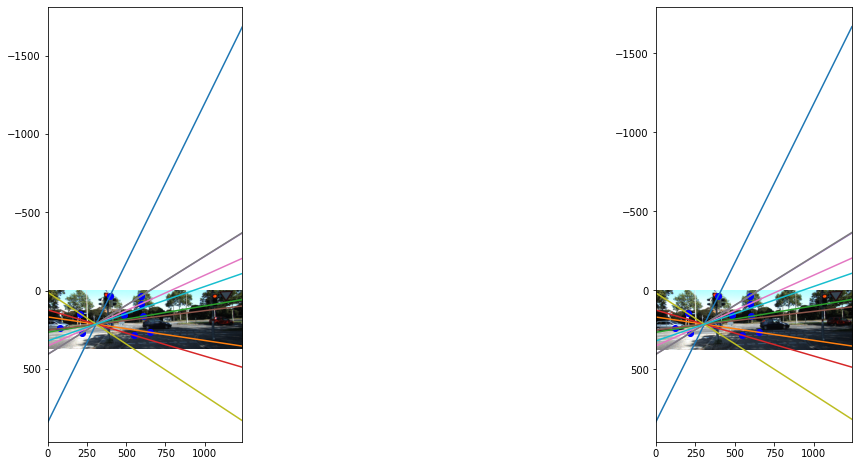

In [15]:
# Singular values for E
E = E_trans.params
Ue,Se,Ve = la.svd(E)

# Randomly select 10 matches (paris of features in two images) from the set of inliers for E
ind_sample = np.random.choice(ind[E_inliers], 10, replace = False)

# Indicate these matching features in image 1 and image 2
plt.figure(6,figsize = (20, 8))
ax61 = plt.subplot(121)
plt.imshow(imL)
plt.plot(ptsL[ind_sample, 0], ptsL[ind_sample, 1], 'ob')
ax62 = plt.subplot(122)
plt.imshow(imR)
plt.plot(ptsR[ind_sample, 0], ptsR[ind_sample, 1], 'ob')

# generate epipolar line equations in image 2 (homoheneous 3-vectors l2 representing lines l2 x  = 0) 
# a. create an array of normalized points sampled in image 1 
n_ptsL_sample = n_ptsL[ind_sample,:]
n_ptsR_sample = n_ptsR[ind_sample,:]
# b. create an array of homogeneous normalized points sampled in image 1 
n_ptsL_sample_homogeneous = np.column_stack((n_ptsL_sample, np.ones(n_ptsL_sample.shape[0])))
n_ptsR_sample_homogeneous = np.column_stack((n_ptsR_sample, np.ones(n_ptsR_sample.shape[0])))
# c. create an array of the corresponding (uncalibrated) epipolar lines in image 2 
n_epipolar_lines_im2 = np.matmul(E, n_ptsL_sample_homogeneous.T)
n_epipolar_lines_im1 = np.matmul(E.T, n_ptsR_sample_homogeneous.T)
# from question 5, we know that the l in the uncalibrated coordinate, is given by K^(-T) l
epipolar_lines_im2 = np.matmul(K_left_inverse.T, n_epipolar_lines_im2).T
epipolar_lines_im1 = np.matmul(K_right_inverse.T, n_epipolar_lines_im1).T


# for each feature (in both images) draw a correspoindiung epipolar line in the other image
# see Assignment 1 (line fitting part 1) for inspiration on how to visualize lines
# use ax41.plot and ax42.plot 
x_start, x_end = 0, 1242
epipolar_x = np.arange(x_start, x_end)

# for each feature (in both images) draw a correspoindiung epipolar line in the other image
# use ax61.plot and ax62.plot 
epipolar_a_im1 = -epipolar_lines_im1[:,0] / epipolar_lines_im1[:,1]
epipolar_a_im2 = -epipolar_lines_im2[:,0] / epipolar_lines_im2[:,1]
epipolar_b_im1 = -epipolar_lines_im1[:,2] / epipolar_lines_im1[:,1]
epipolar_b_im2 = -epipolar_lines_im2[:,2] / epipolar_lines_im2[:,1]

for a, b in zip(epipolar_a_im1, epipolar_b_im1):
    epipolar_y_im1 = a * epipolar_x + b               
    ax61.plot(epipolar_x, epipolar_y_im1)

for a, b in zip(epipolar_a_im2, epipolar_b_im2):
    epipolar_y_im2 = a * epipolar_x + b               
    ax62.plot(epipolar_x, epipolar_y_im2)

plt.show()

#### Step 4: Camera rotation and translation (four solutions)

##### Factorize essential matrix $E=[T]_x R$ where $R$ is rotation and $T$ is a translation. Find solutions $R_1$, $R_2$ and $T_1$, $T_2$. Use camera 1 for world coordinates. Define projection matrix for camera 1 as $P_w = [I|0]$ and compute four projection matrices for the second camera $P_a$, $P_b$, $P_c$, $P_d$.
##### Hint 1: for array multiplication use $dot$ or $matmul$, never $*$. 
##### Hint 2: function  $svd$  from  $linalg$  returns  $V^T$ rather than $V$ (the 2nd orthogonal matrix in svd decomposition $E = USV^T$).
##### Warning: remember that python uses 0 as a starting index for the rows or columns in arrays. For example, $A[0]$ denotes the first row of matrix $A$, while $P_w[2]$ stands for the 3rd row of the corresponding projection matrix and $E[:,[1]]$ is the second column of the essential matrix. 


In [16]:
W = np.array([[0, -1, 0], 
              [1,  0, 0], 
              [0,  0, 1]])

In [17]:
R1 = np.matmul(Ue, np.matmul(W, Ve))
R2 = np.matmul(Ue, np.matmul(W.T, Ve))
T1 = Ue[:, 2]
T2 = -Ue[:, 2]

# first camera matrix
Pw = np.array([[1, 0, 0, 0], 
               [0, 1, 0, 0], 
               [0, 0, 1, 0]])

# four possible matrices for the second camera
Pa = np.column_stack((R1, T1))
Pb = np.column_stack((R1, T2))
Pc = np.column_stack((R2, T1))
Pd = np.column_stack((R2, T2))

#### Summary of Structure-from-Motion (the remaining steps 8-11): 
##### In these 3D reconstruction steps you should use the world coordinate system consistent with the projection matrices estimated in step 7. In all steps you should obtain solutions for all four distinct cases of the second camera: $P_a$, $P_b$, $P_c$, $P_d$. First, step 8 is to Implement least squares (you can use $svd$ or $inv$ functions) for "triangulating" 3D points corresponding to pairs of matched features that are inliers for estimated $E$ (i.e. consistent with the epipolar geometry). Make sure to use normalized coordinates for image points. Then (step 9) you will compute camera positioning (optical centers and calibrated image centers as 3D points) in the world coordinate system. This is used in data visualsation step 10 (fully implemented). That step visulaizes in 3D both camera positions (red - optcal centers, green - image centers) and triangulated points (blue) for four possible cases of the second camera. You should identify one case when solution has 3D points in front of both cameras. In the last step 11 you will project 3D points onto each camera, convert to uncalibrated coordinates, and display these projected points (use red) together with the original features (use blue). Observe if the are red and blue points are close in each image.
#### Step 8: Triangulation (four solutions)

In [18]:
# Select normalized coordinates for matched features that are inliers for essential matrix E. 
# Form matrix A in equation AX=0 where X represent 4 vectors (homogeneous representation of 3D point).
# Use your solution for Problem 6.
# Each camera (projection matrix P) will define its own A  

# HINT: to keep it simple, first solve the problem for one match.
def Afrom2pts(xa, xb):
    Aa = np.array([[Pw[0,0]-Pw[2,0]*xa[0], Pw[0,1]-Pw[2,1]*xa[0], Pw[0,2]-Pw[2,2]*xa[0], Pw[0,3]-Pw[2,3]*xa[0]], 
                   [Pw[1,0]-Pw[2,0]*xa[1], Pw[1,1]-Pw[2,1]*xa[1], Pw[1,2]-Pw[2,2]*xa[1], Pw[1,3]-Pw[2,3]*xa[1]], 
                   [Pa[0,0]-Pa[2,0]*xb[0], Pa[0,1]-Pa[2,1]*xb[0], Pa[0,2]-Pa[2,2]*xb[0], Pa[0,3]-Pa[2,3]*xb[0]], 
                   [Pa[1,0]-Pa[2,0]*xb[1], Pa[1,1]-Pa[2,1]*xb[1], Pa[1,2]-Pa[2,2]*xb[1], Pa[1,3]-Pa[2,3]*xb[1]]])

    Ab = np.array([[Pw[0,0]-Pw[2,0]*xa[0], Pw[0,1]-Pw[2,1]*xa[0], Pw[0,2]-Pw[2,2]*xa[0], Pw[0,3]-Pw[2,3]*xa[0]], 
                   [Pw[1,0]-Pw[2,0]*xa[1], Pw[1,1]-Pw[2,1]*xa[1], Pw[1,2]-Pw[2,2]*xa[1], Pw[1,3]-Pw[2,3]*xa[1]], 
                   [Pb[0,0]-Pb[2,0]*xb[0], Pb[0,1]-Pb[2,1]*xb[0], Pb[0,2]-Pb[2,2]*xb[0], Pb[0,3]-Pb[2,3]*xb[0]], 
                   [Pb[1,0]-Pb[2,0]*xb[1], Pb[1,1]-Pb[2,1]*xb[1], Pb[1,2]-Pb[2,2]*xb[1], Pb[1,3]-Pb[2,3]*xb[1]]])

    Ac = np.array([[Pw[0,0]-Pw[2,0]*xa[0], Pw[0,1]-Pw[2,1]*xa[0], Pw[0,2]-Pw[2,2]*xa[0], Pw[0,3]-Pw[2,3]*xa[0]], 
                   [Pw[1,0]-Pw[2,0]*xa[1], Pw[1,1]-Pw[2,1]*xa[1], Pw[1,2]-Pw[2,2]*xa[1], Pw[1,3]-Pw[2,3]*xa[1]], 
                   [Pc[0,0]-Pc[2,0]*xb[0], Pc[0,1]-Pc[2,1]*xb[0], Pc[0,2]-Pc[2,2]*xb[0], Pc[0,3]-Pc[2,3]*xb[0]], 
                   [Pc[1,0]-Pc[2,0]*xb[1], Pc[1,1]-Pc[2,1]*xb[1], Pc[1,2]-Pc[2,2]*xb[1], Pc[1,3]-Pc[2,3]*xb[1]]])

    Ad = np.array([[Pw[0,0]-Pw[2,0]*xa[0], Pw[0,1]-Pw[2,1]*xa[0], Pw[0,2]-Pw[2,2]*xa[0], Pw[0,3]-Pw[2,3]*xa[0]], 
                   [Pw[1,0]-Pw[2,0]*xa[1], Pw[1,1]-Pw[2,1]*xa[1], Pw[1,2]-Pw[2,2]*xa[1], Pw[1,3]-Pw[2,3]*xa[1]], 
                   [Pd[0,0]-Pd[2,0]*xb[0], Pd[0,1]-Pd[2,1]*xb[0], Pd[0,2]-Pd[2,2]*xb[0], Pd[0,3]-Pd[2,3]*xb[0]], 
                   [Pd[1,0]-Pd[2,0]*xb[1], Pd[1,1]-Pd[2,1]*xb[1], Pd[1,2]-Pd[2,2]*xb[1], Pd[1,3]-Pd[2,3]*xb[1]]])
    return Aa, Ab, Ac, Ad

#### Solution using least squares: assume homogeneous 3D point $X=[X_1,X_2,X_3,1]$. Then, $AX=0$ gives 4 equations for 3 unknowns. Use approach 1 (inhomogeneous least squares) discussed for homography estimation (Topic 6).

In [19]:
def generate_X(Aa, Ab, Ac, Ad):
    # least squares for solving linear system A_{0:2} X_{0:2} = - A_3 
    Aa_02 = Aa[:,:3]       # the first 3 columns of 4x4 matrix A
    Aa_3  = Aa[:,3]       # the last column on 4x4 matrix A
    Ab_02 = Ab[:,:3]
    Ab_3  = Ab[:,3]
    Ac_02 = Ac[:,:3]
    Ac_3  = Ac[:,3]
    Ad_02 = Ad[:,:3]
    Ad_3  = Ad[:,3]

    # Nx3 matrices: N rows with 3D point coordinates for N reconstructed points (N=num_inliers)
    inv_ATAa = la.inv(np.matmul(Aa_02.T, Aa_02))
    Xa = np.matmul(inv_ATAa, np.matmul(Aa_02.T, -Aa_3))

    inv_ATAb = la.inv(np.matmul(Ab_02.T, Ab_02))
    Xb = np.matmul(inv_ATAb, np.matmul(Ab_02.T, -Ab_3))

    inv_ATAc = la.inv(np.matmul(Ac_02.T, Ac_02))
    Xc = np.matmul(inv_ATAc, np.matmul(Ac_02.T, -Ac_3))

    inv_ATAd = la.inv(np.matmul(Ad_02.T, Ad_02))
    Xd = np.matmul(inv_ATAd, np.matmul(Ad_02.T, -Ad_3))
    return Xa, Xb, Xc, Xd

Now we shall traverse each matched inliers to get all of the $X$s.

In [20]:
Xa_list = []
Xb_list = []
Xc_list = []
Xd_list = []

for indx in ind[E_inliers]:
    xa = n_ptsL[indx,:].flatten()
    xb = n_ptsR[indx,:].flatten()

    Aa, Ab, Ac, Ad = Afrom2pts(xa, xb)
    Xa, Xb, Xc, Xd = generate_X(Aa, Ab, Ac, Ad)

    Xa_list.append(Xa)
    Xb_list.append(Xb)
    Xc_list.append(Xc)
    Xd_list.append(Xd)

In [ ]:
Xa = np.vstack(Xa_list)
Xb = np.vstack(Xb_list)
Xc = np.vstack(Xc_list)
Xd = np.vstack(Xd_list)

#### Step 9: Camera positioning in 3D  (four solutions)
##### In this step you will compute location of each cameras' optical center and its (calibrated) image center as points in 3D (world coordinate system). The next step 10 visulaizes the computed cameras' optical centers in red and image centers in green.

In [21]:
# camera's optical centers (for pair of cameras) as points in 3D world coordinate system
# 2x3 matrices: two rows with 3D point coordinates for the first and second camera

# Recall the definition of Ps
# Pa = np.column_stack((R1, T1))
# Pb = np.column_stack((R1, T2))
# Pc = np.column_stack((R2, T1))
# Pd = np.column_stack((R2, T2))

# From problem 2
R1_inv = la.inv(R1)
R2_inv = la.inv(R2)
Ca = np.stack((np.array([0, 0, 0]), np.matmul(R1_inv, -T1)))
Cb = np.stack((np.array([0, 0, 0]), np.matmul(R1_inv, -T2)))
Cc = np.stack((np.array([0, 0, 0]), np.matmul(R2_inv, -T1)))
Cd = np.stack((np.array([0, 0, 0]), np.matmul(R2_inv, -T2)))

# calibrated/normalized image centers (for pair of cameras) as points in 3D world coordinate system
# 2x3 matrices: two rows with 3D po### Step 9: Cameras positions/orientations in 3D  (four solutions)int coordinates for the first and second camera
Qa = np.stack((np.array([0, 0, 1]), np.matmul(R1_inv, np.array([0, 0, 1])-T1)))
Qb = np.stack((np.array([0, 0, 1]), np.matmul(R1_inv, np.array([0, 0, 1])-T2)))
Qc = np.stack((np.array([0, 0, 1]), np.matmul(R2_inv, np.array([0, 0, 1])-T1)))
Qd = np.stack((np.array([0, 0, 1]), np.matmul(R2_inv, np.array([0, 0, 1])-T2)))

print (Cc)
print (Qc)

[[ 0.          0.          0.        ]
 [-0.37542383 -0.01005212  0.92679874]]
[[0.         0.         1.        ]
 [0.32052642 0.00862444 0.20895166]]


#### Step 10: 3D visualization of cameras and triangulated points (four solutions)

IndexError: ignored

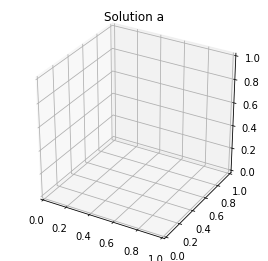

In [22]:
# visualization part
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(10,figsize = (10, 10))

ax10_1 = plt.subplot(221, projection='3d')
plt.title('Solution a')
ax10_1.scatter(Xa[:,0],Xa[:,1],Xa[:,2], c='b', marker='p')
ax10_1.scatter(Ca[:,0],Ca[:,1],Ca[:,2], c='r', marker='p')
ax10_1.scatter(Qa[:,0],Qa[:,1],Qa[:,2], c='g', marker='p')

ax10_2 = plt.subplot(222, projection='3d')
plt.title('Solution b')
ax10_2.scatter(Xb[:,0],Xb[:,1],Xb[:,2], c='b', marker='p')
ax10_2.scatter(Cb[:,0],Cb[:,1],Cb[:,2], c='r', marker='p')
ax10_2.scatter(Qb[:,0],Qb[:,1],Qb[:,2], c='g', marker='p')

ax10_3 = plt.subplot(223, projection='3d')
plt.title('Solution c')
ax10_3.scatter(Xc[:,0],Xc[:,1],Xc[:,2], c='b', marker='p')
ax10_3.scatter(Cc[:,0],Cc[:,1],Cc[:,2], c='r', marker='p')
ax10_3.scatter(Qc[:,0],Qc[:,1],Qc[:,2], c='g', marker='p')

ax10_4 = plt.subplot(224, projection='3d')
plt.title('Solution d')
ax10_4.scatter(Xd[:,0],Xd[:,1],Xd[:,2], c='b', marker='p')
ax10_4.scatter(Cd[:,0],Cd[:,1],Cd[:,2], c='r', marker='p')
ax10_4.scatter(Qd[:,0],Qd[:,1],Qd[:,2], c='g', marker='p')

plt.show()

In [ ]:
def get_proj_pts(P1, P2, pts3D):
    # a. convert correct points (Xa, Xb, Xc, or Xd) to homogeneous 4 vectors
    pts3D_homogeneous = np.column_stack((pts3D, np.ones(pts3D.shape[0])))

    # b. project homogeneous 3D points (onto uncalibrated cameras) using correct Projection matrices (KPw and, e.g. KPa)
    ptsL_proj_homogeneous = np.matmul(np.matmul(K, P1), pts3D_homogeneous.T).T
    ptsR_proj_homogeneous = np.matmul(np.matmul(K, P2), pts3D_homogeneous.T).T
    ptsL_scale = np.column_stack((ptsL_proj_homogeneous[:, 2], ptsL_proj_homogeneous[:, 2]))
    ptsR_scale = np.column_stack((ptsR_proj_homogeneous[:, 2], ptsR_proj_homogeneous[:, 2]))

    # c. convert to regular (inhomogeneous) point
    ptsL_proj = ptsL_proj_homogeneous[:, :2] / ptsL_scale
    ptsR_proj = ptsR_proj_homogeneous[:, :2] / ptsR_scale
    
    return ptsL_proj, ptsR_proj

<IPython.core.display.Javascript object>


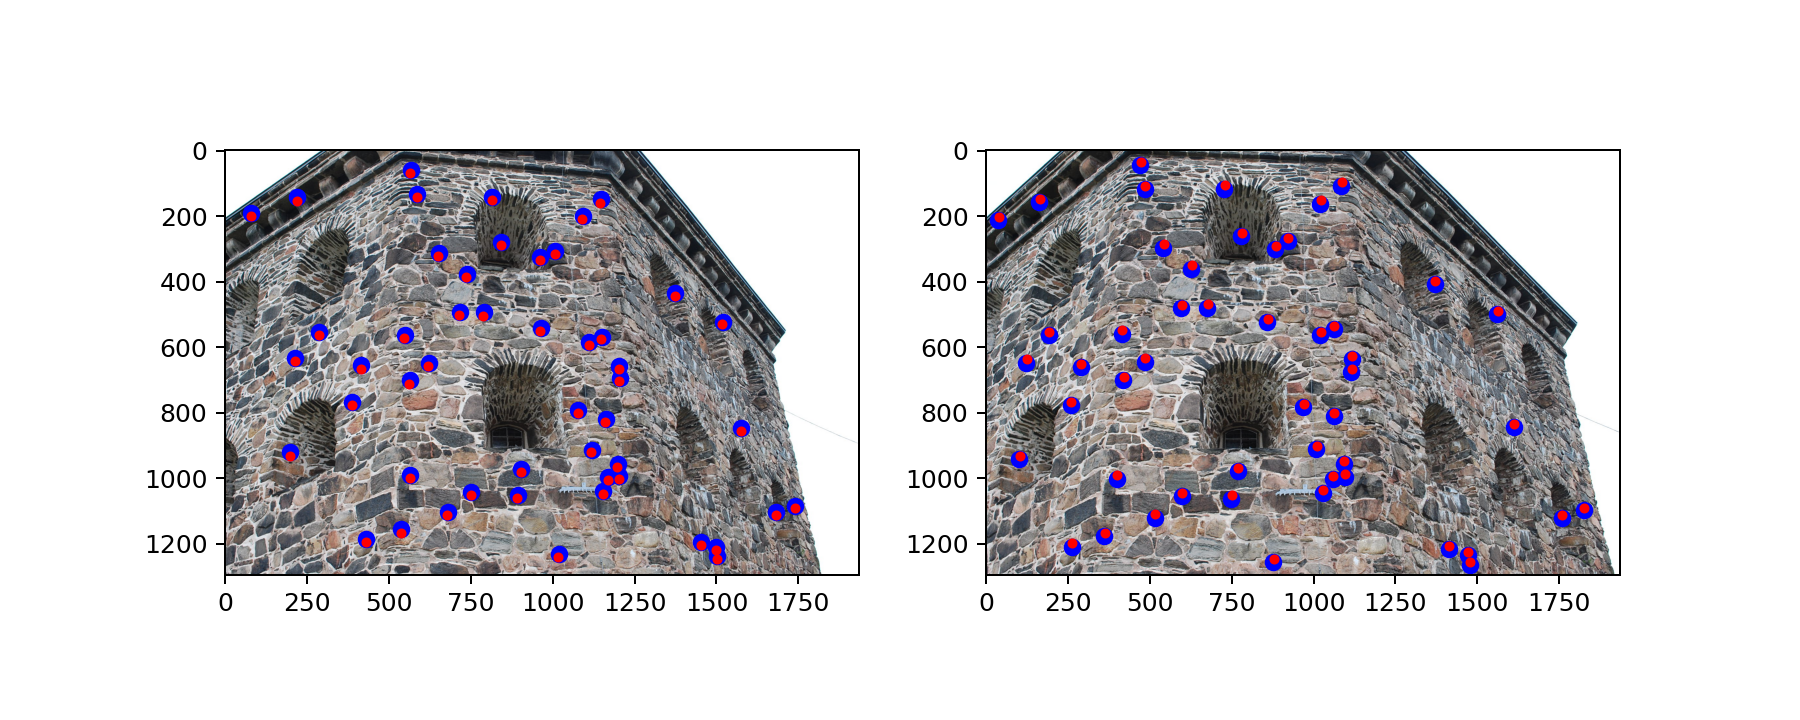

In [ ]:
# Randomly select N=50 matches (pairs of features in two images) from the set of inliers for E
N = 50
ind_sample2 = np.random.choice(num_inliers, N, replace = False)

# Indicate (E) inlier matches in image 1 and image 2
plt.figure(11,figsize = (10, 4))
ax11_1 = plt.subplot(121)
plt.imshow(imL)
plt.plot(ptsL[ind[E_inliers][ind_sample2], 0], ptsL[ind[E_inliers][ind_sample2], 1], 'ob')
ax11_2 = plt.subplot(122)
plt.imshow(imR)
plt.plot(ptsR[ind[E_inliers][ind_sample2], 0], ptsR[ind[E_inliers][ind_sample2], 1], 'ob')

# project reconstructed 3D points onto both images and display them in red color
pts3D = Xa[ind_sample2]
ptsL_proj, ptsR_proj = get_proj_pts(Pw, Pa, pts3D)
ax11_1.plot(ptsL_proj[:,0], ptsL_proj[:,1], '.r')
ax11_2.plot(ptsR_proj[:,0], ptsR_proj[:,1], '.r')

plt.show()

## Conclusion


You should include a cell with two-three paragraphs summarizing the conclusions of your project.
